# Multi-Resolution Multi-Robot experiments

Experiments with the various components of the multi-resolution multi-robot paper. As some of these experiments generate figures for the paper, we are still loading an experiment/run of type nrobot1day, just to set up an output directory.

In [1]:
import sys
sys.path.append("../..")
from exp_run_config import Config
Config.PROJECTNAME = "WaterBerryFarms"

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.lines as lines
import textwrap
import pathlib

import numpy as np
from papers.y2025_mrmr.exploration_package import ExplorationPackage, ExplorationPackageSet
from papers.y2025_mrmr.epmarket import EPAgent, EPOffer, EPMarket
from papers.y2025_mrmr.xyplans import xyplan_from_waypoints, create_random_waypoints, xyplan_from_ep_path
from path_generators import get_path_length, euclidean_distance



## Create a step by step xy plan from a set of waypoints. 

This is basically a replication of the path following algorithm. 
We could put these into path_generators?

In [2]:
waypoints = [[0, 0], [0, 10], [10, 10]]
plan = xyplan_from_waypoints(waypoints, 0) 
print(plan)

[{'t': 0, 'x': 0.0, 'y': 0.0, 'ep': None}, {'t': 1, 'x': 0.0, 'y': 1.0, 'ep': None}, {'t': 2, 'x': 0.0, 'y': 2.0, 'ep': None}, {'t': 3, 'x': 0.0, 'y': 3.0, 'ep': None}, {'t': 4, 'x': 0.0, 'y': 4.0, 'ep': None}, {'t': 5, 'x': 0.0, 'y': 5.0, 'ep': None}, {'t': 6, 'x': 0.0, 'y': 6.0, 'ep': None}, {'t': 7, 'x': 0.0, 'y': 7.0, 'ep': None}, {'t': 8, 'x': 0.0, 'y': 8.0, 'ep': None}, {'t': 9, 'x': 0.0, 'y': 9.0, 'ep': None}, {'t': 10, 'x': 0.0, 'y': 10.0, 'ep': None}, {'t': 11, 'x': 1.0, 'y': 10.0, 'ep': None}, {'t': 12, 'x': 2.0, 'y': 10.0, 'ep': None}, {'t': 13, 'x': 3.0, 'y': 10.0, 'ep': None}, {'t': 14, 'x': 4.0, 'y': 10.0, 'ep': None}, {'t': 15, 'x': 5.0, 'y': 10.0, 'ep': None}, {'t': 16, 'x': 6.0, 'y': 10.0, 'ep': None}, {'t': 17, 'x': 7.0, 'y': 10.0, 'ep': None}, {'t': 18, 'x': 8.0, 'y': 10.0, 'ep': None}, {'t': 19, 'x': 9.0, 'y': 10.0, 'ep': None}, {'t': 20, 'x': 10.0, 'y': 10.0, 'ep': None}]


In [3]:
seed = 0
random = np.random.default_rng(seed)
waypoints = create_random_waypoints(random)
print(waypoints)
xyplan = xyplan_from_waypoints(waypoints, t=0)
print(xyplan)

[[0, 0], [63, 26], [4, 1], [81, 91], [60, 72], [54, 93], [81, 0], [85, 3], [72, 17], [86, 54], [29, 42], [2, 12], [67, 64], [61, 38], [99, 98], [68, 65], [68, 38], [13, 72], [52, 31], [48, 88], [93, 35]]
[{'t': 0, 'x': 0.0, 'y': 0.0, 'ep': None}, {'t': 1, 'x': 0.9243739335349757, 'y': 0.38148765510967253, 'ep': None}, {'t': 2, 'x': 1.8487478670699513, 'y': 0.7629753102193451, 'ep': None}, {'t': 3, 'x': 2.773121800604927, 'y': 1.1444629653290175, 'ep': None}, {'t': 4, 'x': 3.6974957341399026, 'y': 1.52595062043869, 'ep': None}, {'t': 5, 'x': 4.621869667674878, 'y': 1.9074382755483623, 'ep': None}, {'t': 6, 'x': 5.546243601209854, 'y': 2.288925930658035, 'ep': None}, {'t': 7, 'x': 6.47061753474483, 'y': 2.6704135857677076, 'ep': None}, {'t': 8, 'x': 7.394991468279805, 'y': 3.0519012408773802, 'ep': None}, {'t': 9, 'x': 8.319365401814782, 'y': 3.433388895987053, 'ep': None}, {'t': 10, 'x': 9.243739335349758, 'y': 3.8148765510967255, 'ep': None}, {'t': 11, 'x': 10.168113268884735, 'y': 4.1

In [4]:
# TODO: here debug xplan_from_ep_path


## Experiments for creating an optimal path through a series of EPs

In [5]:
experiment = "nrobot1day"
run = "mrmr-experiment"
exp = Config().get_experiment(experiment, run)

# a set of pastel colors
COLORS = ["#E69F00", "#56B4E9", "#009E73"]

***ExpRun**: Loading pointer config file:
	/Users/lboloni/.config/WaterBerryFarms/mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	/Users/lboloni/Google Drive/My Drive/LotziStudy/Code/PackageTracking/WaterBerryFarms/settings/WBF-config-szenes.yaml
***ExpRun**: Configuration for exp/run: nrobot1day/mrmr-experiment successfully loaded


In [6]:
def visualize_path(pointlist, area=[], facecolor="yellow", use_arrows= False):

    """Visualize a path (specified as a list of waypoints) and a set of control points (which might have been part of the specification)
    :param area """
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.invert_xaxis()
    # plot the generated path
    xlim_min, xlim_max = np.min(pointlist[:,0])-2, np.max(pointlist[:,0])+2
    ylim_min, ylim_max = np.min(pointlist[:,1])-2, np.max(pointlist[:,1])+2
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # if specified, add the area, and extend the plot 
    if len(area) > 0:
        areapath = Path(area)        
        ax.add_patch(patches.PathPatch(areapath, fill=True, facecolor=facecolor))
        xlim_min, xlim_max = np.min(area[:,0])-2, np.max(area[:,0])+2
        ylim_min, ylim_max = np.min(area[:,1])-2, np.max(area[:,1])+2

    #ax.set_xlim(xlim_min, xlim_max)
    #ax.set_ylim(ylim_min, ylim_max)
    # add the trajectory
    if use_arrows == False:
        path = Path(pointlist)
        ax.add_patch(patches.PathPatch(path, fill=False))
    else:
        previous_point = None
        for point in pointlist:
            if previous_point is not None:
                # don't put an arrow on the short paths
                if euclidean_distance(point, previous_point) > 5:
                    arrowstyle="->"
                else:
                    arrowstyle="-"
                # the shrink parameters are needed to reach a continuous path
                arrow = patches.FancyArrowPatch(previous_point, point, 
                                                    arrowstyle=arrowstyle, mutation_scale=10, color=COLORS[0], shrinkA=0, shrinkB=0)
                ax.add_patch(arrow)
                    
            previous_point = point   
    #plt.show()
    return fig, ax


1821.1001238539702


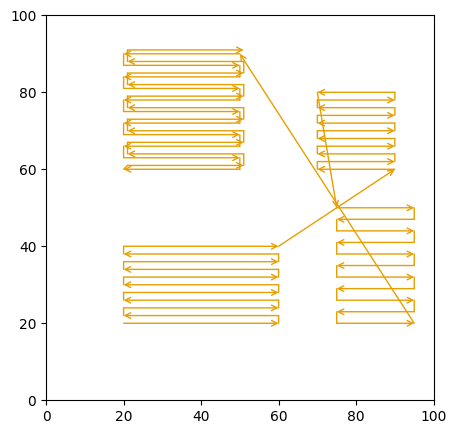

In [7]:
ep1 = ExplorationPackage(20, 60, 20, 40, 2)
path1 = ep1.lawnmower_horizontal_bottom_left()


ep2 = ExplorationPackage(70, 90, 60, 80, 2)
path2 = ep2.lawnmower_horizontal_bottom_right()

ep3 = ExplorationPackage(75, 95, 20, 50, 3)
path3 = ep3.lawnmower_horizontal_top_left()

ep4 = ExplorationPackage(20, 50, 60, 90, 3)
path4= ep4.lawnmower_horizontal_top_right()

path5 = ep4.lawnmower_horizontal_bottom_left(shift=[1,1])


#path = np.concatenate((path1, path2, path3, path4), axis=0)

path = np.concatenate((path1, path2, path3, path4, path5), axis=0)

print(get_path_length(path))

#print(path)
fig, ax = visualize_path(path, use_arrows=True)
#plt.draw()
#plt.show()


### Trying out the exploration package model

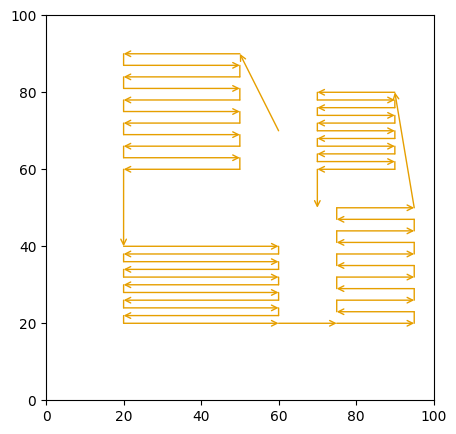

In [8]:
eps = ExplorationPackageSet()

eps.add_ep(ExplorationPackage(20, 60, 20, 40, 2))
eps.add_ep(ExplorationPackage(70, 90, 60, 80, 2))
eps.add_ep(ExplorationPackage(75, 95, 20, 50, 3))
eps.add_ep(ExplorationPackage(20, 50, 60, 90, 3))
# ep5 = ExplorationPackage(10, 20, 10, 20, 2)

# path = eps.find_shortest_path(start=[0,0], end=[0,0])
path, ep_path = eps.find_shortest_path_ep(start=[60,70], end=[70,50])

fig, ax = visualize_path(path, use_arrows=True)

plt.savefig(pathlib.Path(exp.data_dir(), "ep_path.pdf"))

In [9]:
# trying out the xyplan_from_ep_path
xyp = xyplan_from_ep_path(ep_path, t=31)
print(xyp)


[{'t': 31, 'x': 60.0, 'y': 70.0, 'ep': None}, {'t': 32, 'x': 60.0, 'y': 70.0, 'ep': None}, {'t': 33, 'x': 59.55278640450004, 'y': 70.89442719099992, 'ep': None}, {'t': 34, 'x': 59.10557280900008, 'y': 71.78885438199984, 'ep': None}, {'t': 35, 'x': 58.65835921350012, 'y': 72.68328157299976, 'ep': None}, {'t': 36, 'x': 58.21114561800016, 'y': 73.57770876399968, 'ep': None}, {'t': 37, 'x': 57.7639320225002, 'y': 74.4721359549996, 'ep': None}, {'t': 38, 'x': 57.31671842700024, 'y': 75.36656314599952, 'ep': None}, {'t': 39, 'x': 56.86950483150028, 'y': 76.26099033699944, 'ep': None}, {'t': 40, 'x': 56.42229123600032, 'y': 77.15541752799936, 'ep': None}, {'t': 41, 'x': 55.97507764050036, 'y': 78.04984471899928, 'ep': None}, {'t': 42, 'x': 55.5278640450004, 'y': 78.9442719099992, 'ep': None}, {'t': 43, 'x': 55.08065044950044, 'y': 79.83869910099912, 'ep': None}, {'t': 44, 'x': 54.63343685400048, 'y': 80.73312629199904, 'ep': None}, {'t': 45, 'x': 54.18622325850052, 'y': 81.62755348299896, 'ep

[[60.         70.        ]
 [60.         70.        ]
 [59.5527864  70.89442719]
 ...
 [70.         51.        ]
 [70.         50.        ]
 [70.         50.        ]]


(<Figure size 500x500 with 1 Axes>, <Axes: >)

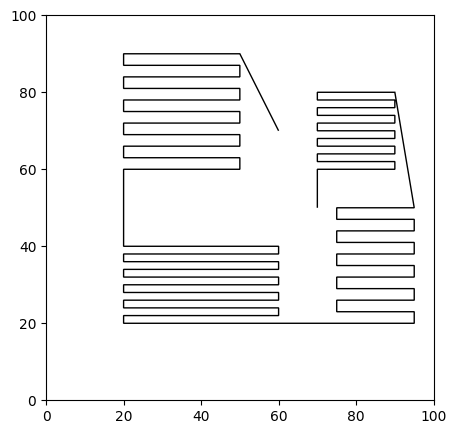

In [12]:
# visualize the xyplan
pointlist = []
for a in xyp:
    pointlist.append([a["x"], a["y"]])
pointlist = np.array(pointlist)
print(pointlist)
visualize_path(pointlist)

## EPMarket

From here: the implementation of a market of EPs and ExpPackPlanningAgents. This will be transferred to a regular python file. 

In [13]:
epm = EPMarket()

agentA = EPAgent("A")
epm.join(agentA)
print(epm)

agentB = EPAgent("B")
epm.join(agentB)

agentC = EPAgent("C")
epm.join(agentC)

# Agent A sends an offer O1, B and C bid on it, the market decides
# on C's favor (it meets the reserve)
# it becomes part of C's commitments and A's 
ep1 = ExplorationPackage(20, 60, 20, 40, 2)
epoff1 = agentA.offer(ep1, 50)

print(epm)
print(agentA)
print(epoff1)

agentB.bid(epoff1, 50)
agentC.bid(epoff1, 48)
epm.clearing() # this will call agentC.won

# Agent A sends an offer O2, nobody bids on it, the offer is cleared up both from the market and from A's outstanding offers
ep2 = ExplorationPackage(10, 20, 10, 20, 3)
epoff2 = agentA.offer(ep1, 10)
print(epm)
epm.clearing() # this will remove everything
print(epm)

# Agent C executes the offer. Pays the findings and receives the prize money.
agentC.commitment_executed(epoff1, 100)




EPMarket:
    Pending offers: []
    Accepted offers: []

EPMarket:
    Pending offers: [EPOffer: {   'assigned_to_name': None,
        'bid_prize': 50,
        'bids': {},
        'ep': ExplorationPackage x=[20,60] y=[20, 40] step=2,
        'executed': False,
        'offering_agent_name': 'A',
        'prize': 50,
        'real_value': 0}]
    Accepted offers: []

Agent: A
    Commitments: []
    Outstanding offers: {EPOffer: {   'assigned_to_name': None,
        'bid_prize': 50,
        'bids': {},
        'ep': ExplorationPackage x=[20,60] y=[20, 40] step=2,
        'executed': False,
        'offering_agent_name': 'A',
        'prize': 50,
        'real_value': 0}: EPOffer: {   'assigned_to_name': None,
        'bid_prize': 50,
        'bids': {},
        'ep': ExplorationPackage x=[20,60] y=[20, 40] step=2,
        'executed': False,
        'offering_agent_name': 'A',
        'prize': 50,
        'real_value': 0}}
    Outstanding bids: {}
    Agreed deals: []
    Terminated dea

In [14]:
results = {"x-code": 50, "value": 70}
results_nc = {}
for a in results:
    if not a.endswith("-code"):
        results_nc[a]=results[a]
print(results_nc)        

{'value': 70}
